In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis

%matplotlib inline

In [3]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
# path = '/Volumes/RT&O/CIS-PD Study/Subjects/' #Mac
path = 'X:\CIS-PD Study\Subjects\\' #Windows
#---------------------------------------------------------------------------------------------------------

newDataFlag = 0
# newData is a flag for whether previously exported .csv data needs to be corrected and, if so, re-exports and overwrites
# old .csv data. Default is 0, which will only write new .csv files which previously did not exist

complete = list(['Heart Rate Variability', 'MDS-UPDRS #1: Finger Tapping',
           'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #3: Pronation-Supination',
           'MDS-UPDRS #4: Toe Tapping', 'MDS-UPDRS #5: Leg Agility',
           'MDS-UPDRS #6: Arising from Chair', 'MDS-UPDRS #7: Gait',
           'MDS-UPDRS #8: Postural Stability', 'MDS-UPDRS #9: Postural Hand Tremor',
           'MDS-UPDRS #10: Kinetic Hand Tremor', 'MDS-UPDRS #11: Rest Tremor',
           'Motor #1: Standing', 'Motor #2: Walking', 'Motor #3: Walking while Counting',
           'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
           'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
           'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
           'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
           'Motor #12: Folding Towels', 'Motor #13: Sitting'])


def process_annotations(path):
#def process_annotations(path, SubID):
#---------------------------------------------------------------------------------------------------------
# Processes raw annotations file to extract start / end timestamps and remove unnecessary data
#
# Inputs:  path - filepath of the subject folder containing annotations.csv
#
# Outputs: df - dataframe containing list of activities and their start / end timestamps
#---------------------------------------------------------------------------------------------------------
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    
    testInfo = df[df.EventType == 'Testing Day'].dropna(how='any', axis=0)
    testInfo['Start Timestamp (ms)'] = pd.to_datetime(testInfo['Start Timestamp (ms)'], unit='ms', utc=True).dt.tz_localize('UTC').dt.tz_convert('US/Central')
    del testInfo['Stop Timestamp (ms)']
    del testInfo['EventType']
    del df['Value']
    
    testInfo = testInfo.rename(columns = {'Value':'Day', 'Start Timestamp (ms)':'Date'}).reset_index(drop=True)
    testInfo['Date'] = testInfo['Date'].dt.date
    
    df = df[(df.EventType != 'Testing Day')]

    # RESIDUAL: Separation into Day 1 and Day 2 data, may re-include at later time
    #Day1 = testInfo.loc[testInfo['Day'] == 'DAY 1', 'Date']
    #Day2 = testInfo.loc[testInfo['Day'] == 'DAY 2', 'Date']

    #d1_df = process_activities(df[df['Start Timestamp (ms)'].dt.date.isin(Day1)].reset_index(drop=True)).set_index('EventType')
    #d2_df = process_activities(df[df['Start Timestamp (ms)'].dt.date.isin(Day2)].reset_index(drop=True)).set_index('EventType')
    
    sorter = set(df.EventType.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))
        
    df['EventType_Rank'] = df['EventType'].map(sorterIndex)
    df['Cycle'] = df.groupby('EventType')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['EventType_Rank']
    #df[df['EventType'].str.contains('MDS-UPDRS')] = df[df['EventType'].str.contains('MDS-UPDRS')].replace(to_replace={'Cycle': {2: 3}})
    df[df['EventType'].str.contains('Heart')] = df[df['EventType'].str.contains('Heart')].replace(to_replace={'Cycle': {1: 'NaN', 2: 'NaN', 3: 'NaN', 4: 'NaN'}})
    df = df.reset_index(drop=True).set_index('EventType')
    
    #df = fix_errors(df, testInfo, SubID, path)
    
    # return d1_df, d2_df, df
    return df, testInfo

## Helper fcns

In [4]:
def extract_data(SubID, path):
#---------------------------------------------------------------------------------------------------------
# For a given subject, extracts and separates accelerometer, gyroscope, and EMG/ECG data into trials and sensor per activity
#
# Inputs: SubID - string of numbers corresponding to the subject ID
#         path - system path to corresponding subject's raw data files
#
# Outputs: act_dict - dictionary of both MDS-UPDRS and Motor Assessment activities separated by trial, sensor location, and
#                     accelerometer + gyroscope or accelerometer + EMG/ECG data. Every key within this dictionary is a dictionary
#---------------------------------------------------------------------------------------------------------
    #timestamps = process_annotations(path, SubID)
    timestamps, testInfo = process_annotations(path)
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                print(location)
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith(('elec.csv', 'emg.csv', 'ecg.csv', 'ekg.csv')):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete}

    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete:
        
        startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
        endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, len(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, len(startTimestamp)):

            startTime = startTimestamp[trials]
            endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]

                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]

                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]

                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    export_data(act_dict, path, SubID, newDataFlag)
    
    return act_dict, timestamps, testInfo



def export_data(act_data, path, SubID, newDataFlag):
#---------------------------------------------------------------------------------------------------------
# Exports accel, gyro, and ecg/emg data correlating with timestamped activities into .csv files into respective folders
#
# Inputs: act_data - dictionary of all activities per subject
#         path - directory path pointing to location of subject folder, generally handled by a higher-level for loop
#         SubID - subject ID to analyze, handled by extract_data function
#         newDataFlag - flag for whether to re-export existing data
#
# Outputs: .csv files of all data separated by activity, sensor location, and start and end timestamps
#---------------------------------------------------------------------------------------------------------
    for activities in act_data:
        
        for trials in act_data[activities]:

            for sensors in act_data[activities][trials]:

                for data in act_data[activities][trials][sensors]:
                    
                    df = act_data[activities][trials][sensors][data]

                    if not df.empty:
                        #filename = data + '_' + str(trials) + '.csv'
                        filename = data + '.csv'
                        act_name = activities.replace(':', ' -')
                        folder = os.path.join('TimeSplitData', SubID, act_name, 'Trial ' + str(trials+1), sensors)
                        
                        if not os.path.isdir(folder):
                            os.makedirs(folder)
                            
                        if newDataFlag:
                            df.to_csv(os.path.join(folder, filename))
                        else:
                            if not os.path.exists(os.path.join(folder, filename)):
                                df.to_csv(os.path.join(folder, filename))
                                
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    toPlot = pd.DataFrame(acts[activity][trial]).loc[data, sensor][start:end].plot(figsize=(6,4))
    

#extract clips for accelerometer and gyro data
def gen_clips(act_dict,task,location,clipsize=5000,overlap=0,verbose=False):
    
    clip_data = {} #the dictionary with clips
    #params
    len_tol = 0.8   #% of the intended clipsize below which clip is not used
    clipsize = 5000 #duration of clip in ms

    for trial in act_dict[task].keys():
        clip_data[trial] = {}            

        for s in ['accel','gyro']:

            if verbose:
                print(task,' sensortype = %s - trial %d'%(s,trial))
            #create clips and store in a list
            rawdata = act_dict[task][trial][location][s]
            #reindex time (relative to start)
            idx = rawdata.index
            idx = idx-idx[0]
            rawdata.index = idx
            #create clips data
            deltat = np.median(np.diff(rawdata.index))
            idx = np.arange(0,rawdata.index[-1],clipsize*(1-overlap))
            clips = []
            for i in idx:
                c = rawdata[(rawdata.index>=i) & (rawdata.index<i+clipsize)]
                if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
                    clips.append(c)
            clip_len = [clips[c].index[-1]-clips[c].index[0] for c in range(len(clips))] #store the length of each clip
            #assemble in dict
            clip_data[trial][s] = {'data':clips, 'clip_len':clip_len}

    return clip_data


#returns power spectra of the signal over each channel between min and max freq at given resolution (nbins)
def powerspectra(x,fm,fM,nbins=10):
    
    #signal features
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
    timestep = 1/Fs 
    freq = np.fft.fftfreq(n,d=timestep) #frequency bins

    #run FFT on each channel 
    Xf = x.apply(np.fft.fft)
    Xf.index = np.round(freq,decimals=1) #reindex w frequency bin
    powXf = Xf.apply(np.abs)
    powXf = powXf**2 #power spectra
    
    #power spectra between 1-10Hz
    bin1 = int(timestep*n*fm)
    bin2 = int(timestep*n*fM)
    bins = np.linspace(bin1,bin2,nbins,dtype=int)
    
    #feature labels
    labels=[]
    s = np.linspace(fm,fM,nbins)
    lax = ['X','Y','Z']
    for l in lax:
        for i in s:
            labels.append('fft'+l+str(int(i)))

    return powXf.iloc[bins,:], labels


#extract features from both sensors (accel and gyro) for current clips and trials
#input: dictionary of clips from each subject
#output: feature matrix from all clips from given subject and scores for each clip
def feature_extraction(clip_data):
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ']
    
    for trial in clip_data.keys():

        for sensor in clip_data[trial].keys():

            #cycle through all clips for current trial and save dataframe of features for current trial and sensor
            features = []
            for c in range(len(clip_data[trial][sensor]['data'])):
                rawdata = clip_data[trial][sensor]['data'][c]
#                 print(rawdata.head(3))
                
                #extract features on current clip
                
                #Energy of signal on each axis
                E = np.asarray(np.sum(rawdata**2,axis=0))
                
                #range on each axis
                min_xyz = np.min(rawdata,axis=0)
                max_xyz = np.max(rawdata,axis=0)
                r = np.asarray(max_xyz-min_xyz)
            
                #Moments on each axis
                mean = np.asarray(np.mean(rawdata,axis=0))
                var = np.asarray(np.std(rawdata,axis=0))
                sk = skew(rawdata)
                kurt = kurtosis(rawdata)
                
                #Power of FFT between 1-10 Hz
                powXf,fft_labels = powerspectra(rawdata,1,10) #dataframe with power spectra for each axis
                xfft = np.asarray([powXf.iloc[:,0].values, powXf.iloc[:,1].values, powXf.iloc[:,2].values])
                xfft = np.reshape(xfft,(1,xfft.size)) #row vector
                xfft = xfft.reshape(-1)

                #Assemble features in array
                x = np.concatenate((E,r,mean,var,sk,kurt,xfft))
#                 x = np.asarray([E,r,mean,var,sk,kurt,xfft]) #features for 1 clip
#                 x = np.reshape(x,(1,x.size)) #row vector
                features.append(x)
                    
            F = np.asarray(features) #feature matrix for all clips from current trial
            F = F.squeeze()            
            clip_data[trial][sensor]['features'] = pd.DataFrame(data=F,columns=features_list+fft_labels,dtype='float32')  
        
#     return clip_data #not necessary

In [5]:
os.listdir(path+'/1020/anterior_thigh_left/d5la7wz0/')

['2017-08-03T17-44-51-148Z']

## Pull data from all the subjects

In [8]:
path #subject raw data folders path
dict_path = 'X:\CIS-PD Study\Data_dict' #data dictionaries path
#localpath = '../Data/'

In [14]:
os.listdir(dict_path)

['1020dict.pkl', '1044dict.pkl']

In [ ]:
#all subj data files in repository
d = os.listdir(path)
f = [filename for filename in d if filename.startswith('1')] #need to update to skip existing files in /data
print(f)
#existing data dictionary files
fd = os.listdir(dict_path)
fd = [x[:4] for x in fd]
print(fd)

#remove subject that failed - need to check w Andrew
f.remove('1030')
f.remove('1032')
f.remove('1024')

In [29]:
#create data dict for remaining subjects
data_all = []
for SubID in list(set(f)-set(fd)):
    print(SubID)
    act_dict, timestamps, testInfo = extract_data(SubID, os.path.join(path, SubID))
    #save dict to Pickle file
    filename = dict_path+'\\'+SubID + 'dict.pkl'
    f = open(filename,'wb')
    pickle.dump(act_dict,f)
    f.close()
    print('File Saved')

1018
anterior_thigh_left
anterior_thigh_left
anterior_thigh_left
anterior_thigh_right
anterior_thigh_right
anterior_thigh_right
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_right
distal_lateral_shank_right
distal_lateral_shank_right
dorsal_hand_left
dorsal_hand_left
dorsal_hand_left
dorsal_hand_right
dorsal_hand_right
dorsal_hand_right
flexor_digitorum_left
flexor_digitorum_left
flexor_digitorum_left
flexor_digitorum_right
flexor_digitorum_right
flexor_digitorum_right
medial_chest
medial_chest
medial_chest
sacrum
sacrum
sacrum
File Saved
1049
anterior_thigh_left
anterior_thigh_left
anterior_thigh_right
anterior_thigh_right
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_right
distal_lateral_shank_right
dorsal_hand_left
dorsal_hand_left
dorsal_hand_right
dorsal_hand_right
flexor_digitorum_left
flexor_digitorum_left
flexor_digitorum_right
flexor_digitorum_right
medial_chest
medial_chest
sacrum
sacrum
File Save

AttributeError: 'numpy.int64' object has no attribute 'values'

In [10]:
SubID = '1020'
act_dict, timestamps, testInfo = extract_data(SubID, os.path.join(path, SubID))

anterior_thigh_left
anterior_thigh_left
anterior_thigh_left
anterior_thigh_right
anterior_thigh_right
anterior_thigh_right
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_left
distal_lateral_shank_right
distal_lateral_shank_right
distal_lateral_shank_right
dorsal_hand_left
dorsal_hand_left
dorsal_hand_left
dorsal_hand_right
dorsal_hand_right
dorsal_hand_right
flexor_digitorum_left
flexor_digitorum_left
flexor_digitorum_left
flexor_digitorum_right
flexor_digitorum_right
flexor_digitorum_right
medial_chest
medial_chest
medial_chest
sacrum
sacrum
sacrum


In [40]:
#save dict to Pickle file
f = open('1020dict.pk1','wb')
pickle.dump(act_dict,f)
f.close()

In [47]:
pd.__version__

'0.20.1'

In [46]:
#load Pickle file dict
f = open(dict_path+'1016dict.pkl','rb')
act_dict = pickle.load(f)
f.close()

ModuleNotFoundError: No module named 'pandas.indexes'

In [26]:
len(act_dict['Motor #8: Typing on a Computer'].keys())

7

In [27]:
act_dict['Motor #8: Typing on a Computer'][1]['medial_chest']['accel'].head()

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
1499961141927,0.163149,0.983963,0.067933
1499961141959,0.173892,0.966873,0.060609
1499961141991,0.167544,0.974197,0.091371
1499961142023,0.161685,0.966873,0.085023
1499961142056,0.147524,0.983963,0.087465


In [11]:
#EXAMPLE of creating dict of dicts
# trial = 0
# s  = 'accel'
# clip_data={}
# clip_data[trial] = {}
# clip_data[trial][s] = clips
# s2 = 'gyro'
# clip_data[trial][s2] = clips
# # clip_data[trial]['size'] = clip_len

In [35]:
rawdata = act_dict['Motor #8: Typing on a Computer'][2]['dorsal_hand_right']['accel']

In [36]:
idx = rawdata.index
idx = idx-idx[0]
rawdata.index = idx
rawdata.head()

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
0,-0.132021,-0.332219,0.889601
16,-0.190738,-0.327581,0.924025
32,-0.213565,-0.332464,0.973098
48,-0.228336,-0.338567,1.033280
64,-0.253727,-0.331975,1.043168


## Clip extraction

In [37]:
clip_data = gen_clips(act_dict,task='Motor #8: Typing on a Computer',location='dorsal_hand_right',overlap=0)

Motor #8: Typing on a Computer  sensortype = accel - trial 0
Motor #8: Typing on a Computer  sensortype = gyro - trial 0
Motor #8: Typing on a Computer  sensortype = accel - trial 1
Motor #8: Typing on a Computer  sensortype = gyro - trial 1
Motor #8: Typing on a Computer  sensortype = accel - trial 2
Motor #8: Typing on a Computer  sensortype = gyro - trial 2
Motor #8: Typing on a Computer  sensortype = accel - trial 3
Motor #8: Typing on a Computer  sensortype = gyro - trial 3
Motor #8: Typing on a Computer  sensortype = accel - trial 4
Motor #8: Typing on a Computer  sensortype = gyro - trial 4
Motor #8: Typing on a Computer  sensortype = accel - trial 5
Motor #8: Typing on a Computer  sensortype = gyro - trial 5
Motor #8: Typing on a Computer  sensortype = accel - trial 6
Motor #8: Typing on a Computer  sensortype = gyro - trial 6


In [38]:
clip_data[0]['accel']['data'][0].head()

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
0,-0.005310,-0.521431,0.825513
16,-0.028260,-0.508614,0.827588
32,-0.042176,-0.475898,0.840406
48,-0.025086,-0.434516,0.837842
64,0.011414,-0.408026,0.836500


In [39]:
clip_data[0]['accel']['clip_len']

[4997, 4981, 4981, 4980, 4981, 4997, 4981]

## Feature extraction

Let's start with the following:
* Energy (total within segment)
* Max
* Min
* Mean
* Variance
* Skewness
* Kurtosis
* Power spectra 0-10 Hz

In [40]:
rawdata = clip_data[0]['accel']['data'][0]

### An example of FFT

49.9


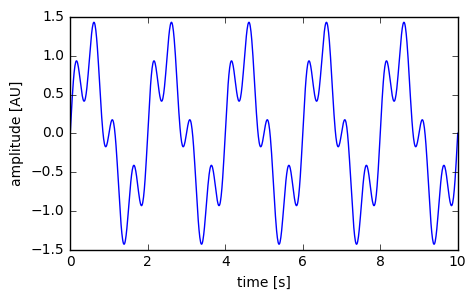

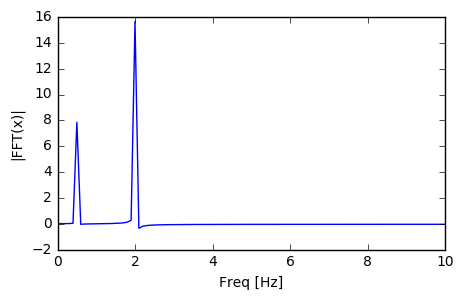

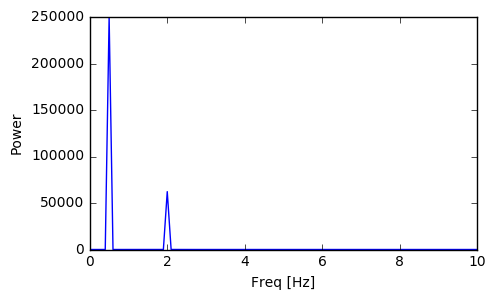

In [90]:
#An example of FFT 
Fs = 100 #sample rate
pi = np.pi

f0 = .5 #cycles per sec
f1 = 2
t = np.linspace(0,10,1000) 
x = np.sin(2*pi*f0*t) + 0.5*np.sin(2*pi*f1*t)
plt.figure(figsize=(5,3))
plt.plot(t,x)
plt.xlabel('time [s]')
plt.ylabel('amplitude [AU]')

Xf = np.fft.fft(x)
n = x.size
timestep = 1/Fs
freq = np.fft.fftfreq(n,d=timestep)
print(max(freq))
plt.figure(figsize=(5,3))
plt.plot(freq[:int(n/2)],Xf.real[:int(n/2)])
plt.xlim([0,10])
plt.xlabel('Freq [Hz]')
plt.ylabel('|FFT(x)|')

powXf = np.abs(Xf)**2 #power spectrum
plt.figure(figsize=(5,3))
plt.plot(freq[:int(n/2)],powXf[:int(n/2)])
plt.xlim([0,10])
plt.xlabel('Freq [Hz]')
plt.ylabel('Power')

In [33]:
rawdata = clip_data[0]['accel']['data'][0]

In [399]:
#feature calculation test
# E = np.asarray(np.sum(rawdata**2,axis=0))
# mean = np.asarray(np.mean(rawdata,axis=0))
# var = np.asarray(np.std(rawdata,axis=0))
# sk = skew(rawdata)
# kurt = kurtosis(rawdata)
# min_xyz = np.min(rawdata,axis=0)
# max_xyz = np.max(rawdata,axis=0)
# r = np.asarray(max_xyz-min_xyz)
        
# xfft = np.asarray([powXf.iloc[:,0].values,powXf.iloc[:,1].values,powXf.iloc[:,2].values])
# xfft = np.reshape(xfft,(1,xfft.size)) #row vector
# xfft = xfft.reshape(-1)

# x = np.concatenate((E,r,mean,var,sk,kurt,xfft))
# x.shape

(48,)

** Plot power spectra from one clip **

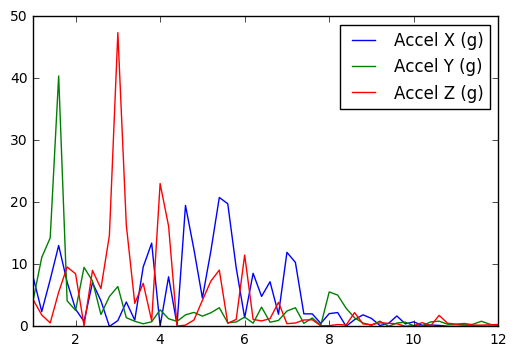

In [44]:
powXf,fft_labels = powerspectra(rawdata,1,12,nbins=60) #dataframe with power spectra for each axis
powXf.plot()

In [120]:
feature_extraction(clip_data)

In [46]:
clip_data[1]['gyro']['features']

,EX,EY,EZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,fftZ1,fftZ2,fftZ3,fftZ4,fftZ5,fftZ6,fftZ7,fftZ8,fftZ9,fftZ10
0,183731.046875,97822.968750,104499.976562,175.783936,109.315636,112.123291,1.412118,-1.559540,2.395325,24.186899,...,6.424227e+05,1.290122e+06,262516.875000,149861.265625,44820.976562,130757.687500,71877.500000,41721.449219,34678.441406,21060.314453
1,150487.625000,51027.214844,106810.195312,142.153046,74.402992,105.409325,1.295452,0.256469,1.658538,21.923820,...,2.537064e+06,2.307103e+06,94380.312500,45695.347656,66777.890625,67600.617188,79620.914062,12759.038086,32671.330078,26529.185547
2,142697.593750,69997.656250,73410.484375,151.735718,103.517204,91.004807,0.601949,-0.962492,1.011008,21.377600,...,1.430133e+06,2.288326e+05,132977.062500,94573.632812,171999.546875,98673.757812,48973.000000,66205.851562,4476.731934,6938.508301
3,124516.570312,78548.710938,144801.265625,127.504387,89.234756,110.841537,2.477830,0.955450,1.642692,19.823015,...,4.923859e+06,4.983990e+05,59559.316406,312044.906250,909.007751,281932.968750,10474.378906,15924.381836,30167.529297,3290.486328
4,108716.460938,49680.847656,121761.632812,118.776230,75.074387,107.667656,1.528054,-0.093706,0.929627,18.604174,...,2.316762e+06,3.080867e+05,111801.390625,144888.781250,41090.222656,55674.832031,8034.803711,273.992920,7331.311035,7239.675293
5,111604.640625,50818.906250,51565.582031,145.754181,89.356834,70.679787,0.866303,-0.279537,3.816120,18.863029,...,1.609756e+04,3.923681e+05,56246.039062,3613.634766,62987.441406,74199.687500,1444.992798,27577.410156,2378.953125,3474.323975
6,118847.320312,61083.832031,99253.273438,126.771957,93.629356,103.944458,1.265912,-0.317114,3.567481,19.476097,...,2.888770e+06,1.282959e+06,452877.031250,79129.195312,8196.410156,13574.288086,215595.015625,22510.226562,34691.855469,10917.945312


In [47]:
f  = clip_data[0]['accel']['features']

In [48]:
f

,EX,EY,EZ,rangeX,rangeY,rangeZ,meanX,meanY,meanZ,varX,...,fftZ1,fftZ2,fftZ3,fftZ4,fftZ5,fftZ6,fftZ7,fftZ8,fftZ9,fftZ10
0,5.938424,31.773273,280.518982,0.680186,0.527352,0.512337,-0.105801,-0.306558,0.943759,0.088198,...,4.276775,8.489310,47.389416,23.048323,4.208512,11.512398,0.442636,0.126569,0.287934,0.138153
1,4.519738,34.106918,279.038727,0.457160,0.582650,0.448127,-0.094599,-0.318645,0.943605,0.074413,...,0.295072,8.469069,1.888998,15.323736,2.449586,5.691412,6.831175,2.049203,0.275177,0.257576
2,4.262351,29.904043,282.681427,0.499275,0.421515,0.471321,-0.088216,-0.301264,0.950159,0.076677,...,0.004144,6.496552,0.671401,1.177088,1.725019,4.874147,8.379904,0.955951,0.737272,0.052297
3,6.434051,22.204058,290.635773,0.387823,0.606088,0.425055,-0.131714,-0.256273,0.962242,0.057213,...,1.684216,20.276751,19.376377,10.075887,11.379268,1.257462,0.008297,2.050742,0.948612,0.754825
4,6.427450,24.443144,288.059814,0.448493,0.507576,0.484993,-0.116845,-0.269743,0.958080,0.083354,...,2.038278,9.247272,11.992784,4.655787,10.581113,4.487783,6.283818,0.049111,1.796664,0.728336
5,6.116734,29.097414,282.581512,0.381476,0.436896,0.460456,-0.122706,-0.290203,0.947909,0.066974,...,0.761695,6.689026,6.828301,17.574675,19.074032,3.324242,0.739972,0.035685,0.351003,0.211929
6,7.292502,17.348431,295.660736,0.520394,0.660655,0.450446,-0.133373,-0.220437,0.970844,0.074733,...,1.331588,26.708088,4.209696,5.308475,2.963188,1.747721,3.833246,2.228975,0.188508,0.014880


## Aggregate features data with scores for given task - cycle through all subjects
for s in subjects:
*    load score files
*    load subject file
*    choose task and sensor location
*    extract clips
*    compute features on each trial
*    Aggregate subj code and score with feature matrix

**Note: gyro data has to be added **

In [196]:
#define task and sensor location
task = 'Motor #8: Typing on a Computer'
task_scores = 'Typing on a computer keyboard' #the task name in the scores file
loc = 'dorsal_hand_right'

#load subject scores
scores_path = '../Scores/'
mot_scores = pd.read_excel(os.path.join(scores_path, 'MotorTasks.xls'))

#load subjects features data and assemble with scores/subj metadata
subj_path = '../Data/'
d = os.listdir(subj_path)
fnames = [filename for filename in d if filename.startswith('1')]
print(fnames)

Data = pd.DataFrame() #the table with all data
for subj_filename in fnames:

    #extract current subject scores and metadata
    subj = int(subj_filename[:4]) #subj code
    subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
                                task_scores+ ' ' + 'bradykinesia right upper limb rating (Q94)',
                                task_scores+ ' ' + 'tremor right upper limb rating (Q98)']]
    subj_score = subj_score.rename(index=str,columns={subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right' })
    subj_score.index = range(len(subj_score))
    if len(subj_score) < 1:
        print('no scores data for subject %d'%subj)
 
    #load subject sensor data Pickle file (dictionary)
    else:
        f = open(os.path.join(subjpath,subj_filename),'rb')    
        act_dict = pickle.load(f)
        f.close()
        print('\nLoaded Subj %s sensor data'%subj)

        #generate clips and extract features
        clip_data = gen_clips(act_dict,task=task,location=loc,overlap=0)
        feature_extraction(clip_data)
        
        #aggreagate subject, scores and features data
        n_visits = len(subj_score)    #of visits in Database
        n_rec = len(clip_data.keys()) #of sensor recordings
        print('n_visits = %d, # recordings = %d'%(n_visits,n_rec))
        N = n_visits

        if n_visits != n_rec:
            print('# of recordings does not match # of visits! - matching first %d recordings'%(min([n_visits,n_rec])))
            N = min([n_visits,n_rec])

        #aggregate data from each visit for current subject
        for i in range(N):
            #features
            D = clip_data[i]['accel']['features']
            featcols = D.columns.tolist()
            #scores
            D['Bradykinesia right'] = subj_score['Bradykinesia right'][i]
            D['Tremor right'] = subj_score['Tremor right'][i]
            #metadata
            D['Visit'] = subj_score.Visit[i] 
            D['Task'] = task
            D['Location'] = loc 
            D['Subject'] = subj
            Data = pd.concat([Data,D]) #concatenate data from each visit

cols = ['Subject','Visit','Task','Location','Bradykinesia right','Tremor right']+ featcols
Data = Data[cols]    
print('Data matrix generated')
print(Data.shape)

['1004dict.pkl', '1016dict.pkl', '1018dict.pkl', '1019dict.pkl', '1020dict.pkl']

Loaded Subj 1004 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1016 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1018 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1019 sensor data
n_visits = 7, # recordings = 7

Loaded Subj 1020 sensor data
n_visits = 1, # recordings = 6
# of recordings does not match # of visits! - matching first 1 recordings
Data matrix generated
(206, 54)


In [197]:
Data.head()

,Subject,Visit,Task,Location,Bradykinesia right,Tremor right,EX,EY,EZ,rangeX,...,fftZ1,fftZ2,fftZ3,fftZ4,fftZ5,fftZ6,fftZ7,fftZ8,fftZ9,fftZ10
0,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,1,0.989795,44.348713,294.357025,0.295659,...,0.255014,0.088320,0.157466,0.675251,0.032196,0.159398,0.426222,0.256522,0.280770,0.021760
1,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,1,0.980724,46.307796,292.087341,0.302373,...,5.107076,0.718339,0.271236,0.658706,0.156225,0.203359,2.374330,0.822733,0.459779,0.320006
2,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,1,0.464513,43.768703,295.375275,0.207767,...,0.647708,0.432310,0.320638,0.170064,0.722563,0.185477,0.619560,0.220267,0.682122,0.343600
3,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,1,0.526413,39.445747,299.413147,0.200931,...,0.480207,0.045108,0.007973,0.018898,0.124466,0.101372,0.279455,1.155170,0.172063,0.109135
4,1004,2 Weeks: Time 0,Motor #8: Typing on a Computer,dorsal_hand_right,2,1,0.754654,42.991791,295.756226,0.219974,...,5.170502,0.633635,0.085683,0.424799,0.140160,0.177459,0.070148,0.053567,0.096655,0.247305


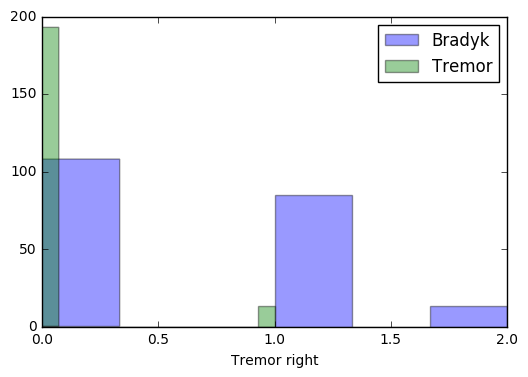

In [207]:
plt.figure()
# plt.subplot(211)
sns.distplot(Data['Bradykinesia right'],kde=False)
sns.distplot(Data['Tremor right'],kde=False)
plt.legend(['Bradyk','Tremor'])

## Tests on individual subjects / features

In [49]:
#load subject scores
path = '../Scores/'
mot_scores = pd.read_excel(os.path.join(path, 'MotorTasks.xls'))

In [50]:
mot_scores[mot_scores['Subject']==1016].head(3)

,Site,Subject,Visit,CRF#,Data Collected (Qa),Date of assessment (Qb),What is the participants state (Q02),On which hand is the subject wearing the Apple watch (Q03),Was the device shaken 5 times up and down prior to beginning the assessment (Q04),Patients Apple watch clock time when the stop watch is turned on (Q146),...,Folding towels tremor left upper limb rating (Q137),Folding towels tremor right upper limb rating (Q138),Was sitting assessed (Q139),Sitting start time (Q140),Sitting end time (Q141),Sitting dyskinesia left upper limb rating (Q142),Sitting dyskinesia right upper limb rating (Q143),Sitting tremor left upper limb rating (Q144),Sitting tremor upper right limb rating (Q145),General Comments (Qc)
6,"Northwestern Memorial Hospital, Chicago, IL",1016,2 Weeks: Time 0,602,Yes,2017-07-13,Off,Left,Yes,09:52:55,...,1,1,Yes,00:14:07,00:14:37,0,0,0,0,NaN
7,"Northwestern Memorial Hospital, Chicago, IL",1016,2 Weeks: Time 30,644,Yes,2017-07-13,Off,Left,Yes,10:44:52,...,1,1,Yes,00:12:13,00:12:43,0,0,0,0,NaN
8,"Northwestern Memorial Hospital, Chicago, IL",1016,2 Weeks: Time 60,646,Yes,2017-07-13,On,Left,Yes,11:41:35,...,1,1,Yes,00:12:26,00:12:56,0,0,0,0,NaN


In [93]:
subj = 1016
#extract scores for corresponding task 
task = 'Motor #8: Typing on a Computer'
loc = 'dorsal_hand_right'

subj=1016
subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
#                 'Typing on a computer keyboard overall score (Q92)',
#                 'Typing on a computer keyboard bradykinesia left upper limb rating (Q93)',
#                 'Typing on a computer keyboard tremor left upper limb rating (Q97)',
                'Typing on a computer keyboard bradykinesia right upper limb rating (Q94)',
                'Typing on a computer keyboard tremor right upper limb rating (Q98)']]

subj_score = subj_score.rename(index=str,columns={subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right' })
subj_score.index = range(len(subj_score))
subj_score

,Subject,Visit,Bradykinesia right,Tremor right
0,1016,2 Weeks: Time 0,1,0
1,1016,2 Weeks: Time 30,1,0
2,1016,2 Weeks: Time 60,1,0
3,1016,2 Weeks: Time 90,1,0
4,1016,2 Weeks: Time 120,1,0
5,1016,2 Weeks: Time 150,1,0
6,1016,1 Month,2,0


In [121]:
#aggreagate subject, scores and features data
Data = pd.DataFrame()
D = pd.DataFrame()

n_visits = len(subj_score)    # # of visits in Database
n_rec = len(clip_data.keys()) # # of sensor recordings
print('n_visits = %d, # recordings = %d'%(n_visits,n_rec))
N = n_visits

if n_visits != n_rec:
    print('# of recordings does not match # of visits! - matching first %d recordings')%(min([n_visits,n_rec]))
    N = min([n_visits,n_rec])

for i in range(N):
    #features
    D = clip_data[i]['accel']['features']
    featcols = D.columns.tolist()
    #scores
    D['Bradykinesia right'] = subj_score['Bradykinesia right'][i]
    D['Tremor right'] = subj_score['Tremor right'][i]
    #metadata
    D['Visit'] = subj_score.Visit[i] 
    D['Task'] = task
    D['Location'] = loc 
    Data = pd.concat([Data,D]) #concatenate data from each visit
    
Data['Subject'] = subj 
cols = ['Subject','Visit','Task','Location','Bradykinesia right','Tremor right']+ featcols
Data = Data[cols]    
    

n_visits = 7, # recordings = 7


In [122]:
D.columns

Index(['EX', 'EY', 'EZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX', 'meanY',
       'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ', 'kurtX',
       'kurtY', 'kurtZ', 'fftX1', 'fftX2', 'fftX3', 'fftX4', 'fftX5', 'fftX6',
       'fftX7', 'fftX8', 'fftX9', 'fftX10', 'fftY1', 'fftY2', 'fftY3', 'fftY4',
       'fftY5', 'fftY6', 'fftY7', 'fftY8', 'fftY9', 'fftY10', 'fftZ1', 'fftZ2',
       'fftZ3', 'fftZ4', 'fftZ5', 'fftZ6', 'fftZ7', 'fftZ8', 'fftZ9', 'fftZ10',
       'Bradykinesia right', 'Tremor right', 'Visit', 'Task', 'Location'],
      dtype='object')

In [78]:
Data_acc = clip_data[0]['accel']['features']
Data_gyr = clip_data[0]['accel']['features']
print(Data_acc.shape,Data_gyr.shape)
Data = pd.concat([Data_acc,Data_gyr],axis=1)
print(Data.shape)

(7, 49) (7, 49)
(7, 98)


# Visualize different tasks

In [22]:
act_dict.keys()

dict_keys(['MDS-UPDRS #6: Arising from Chair', 'Motor #2: Walking', 'Motor #6: Sit to Stand', 'MDS-UPDRS #11: Rest Tremor', 'Motor #3: Walking while Counting', 'Heart Rate Variability', 'MDS-UPDRS #3: Pronation-Supination', 'Motor #5: Alternating Hand Movements', 'MDS-UPDRS #7: Gait', 'Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels', 'MDS-UPDRS #2: Hand Movements', 'MDS-UPDRS #4: Toe Tapping', 'Motor #13: Sitting', 'MDS-UPDRS #5: Leg Agility', 'Motor #9: Nuts and Bolts', 'MDS-UPDRS #8: Postural Stability', 'Motor #1: Standing', 'MDS-UPDRS #1: Finger Tapping', 'MDS-UPDRS #9: Postural Hand Tremor', 'Motor #7: Drawing on Paper', 'MDS-UPDRS #10: Kinetic Hand Tremor', 'Motor #8: Typing on a Computer', 'Motor #4: Finger to Nose'])

In [25]:
act_dict['Motor #10: Drinking Water'][0].keys()

dict_keys(['anterior_thigh_right', 'distal_lateral_shank_right', 'sacrum', 'flexor_digitorum_right', 'dorsal_hand_left', 'medial_chest', 'dorsal_hand_right', 'distal_lateral_shank_left', 'anterior_thigh_left', 'flexor_digitorum_left'])

In [1]:
tasks= ['Motor #13: Sitting','Motor #6: Sit to Stand','Motor #2: Walking','Motor #8: Typing on a Computer','Motor #4: Finger to Nose']
trials = [0,5]
# locs = ['dorsal_hand_right','flexor_digitorum_right','sacrum','anterior_thigh_right']
# sensor = ['accel','gyro']

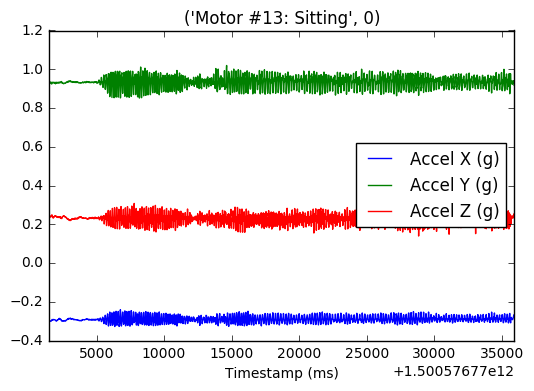

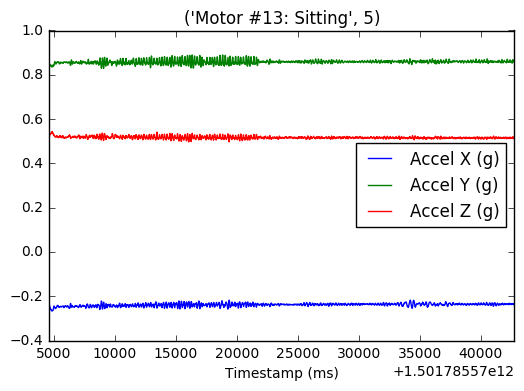

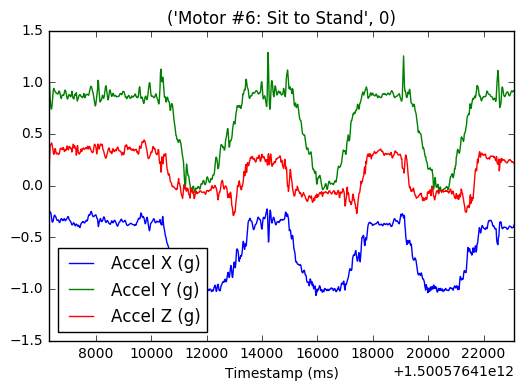

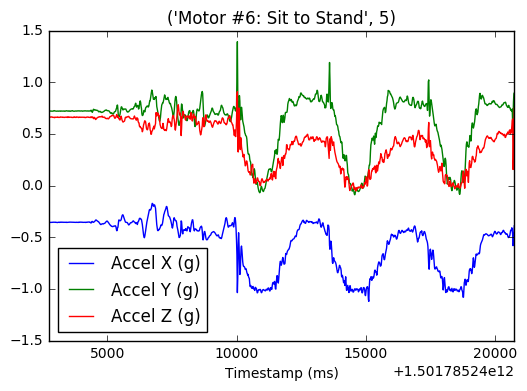

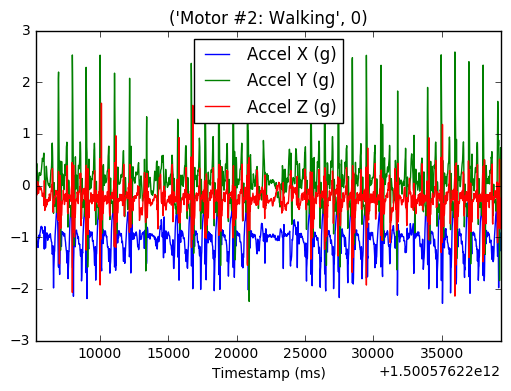

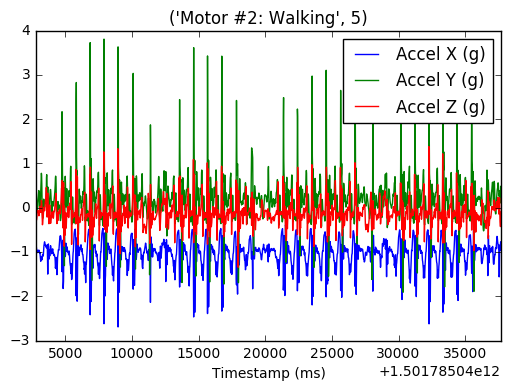

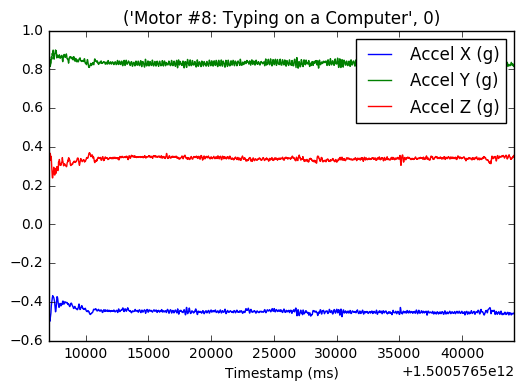

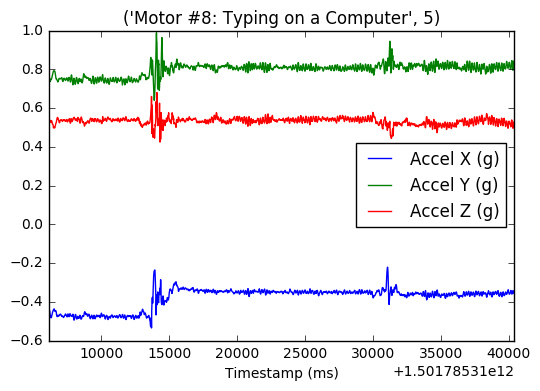

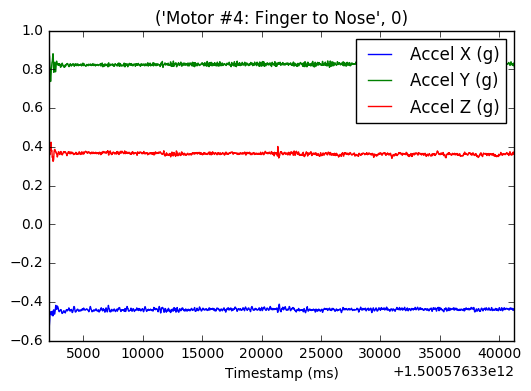

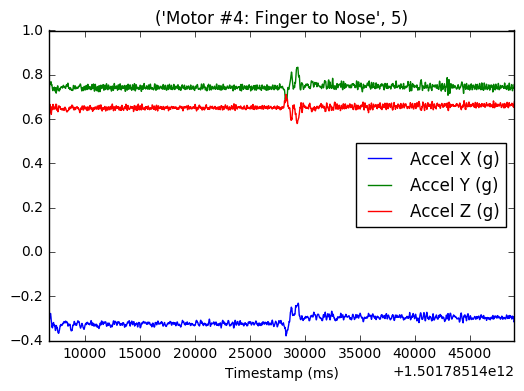

In [11]:
p = product(tasks,trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],'anterior_thigh_right','accel')
    plt.title(t)

In [83]:
#test itertools
from itertools import product
t = ('T1','T2')
l = (1,2)
s = ('s1','s2')
# print(list(product(t,l,s)))
taskslist = list(product(t,l,s))
for t in taskslist:
    print(t)

('T1', 1, 's1')
('T1', 1, 's2')
('T1', 2, 's1')
('T1', 2, 's2')
('T2', 1, 's1')
('T2', 1, 's2')
('T2', 2, 's1')
('T2', 2, 's2')


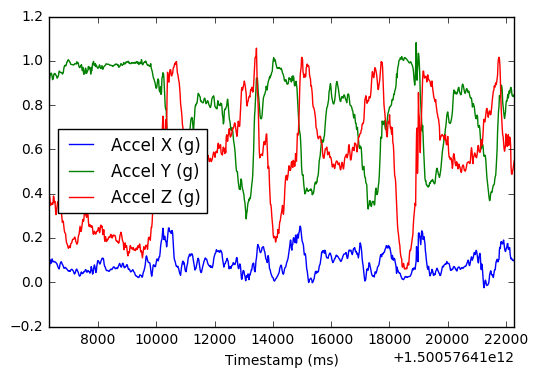

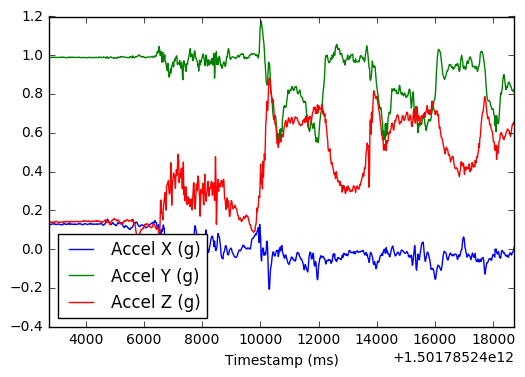

In [59]:
plot_data(act_dict,'Motor #6: Sit to Stand',0,'sacrum','accel')
plot_data(act_dict,'Motor #6: Sit to Stand',5,'sacrum','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'anterior_thigh_left','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'anterior_thigh_left','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'flexor_digitorum_right','accel')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'flexor_digitorum_right','accel')


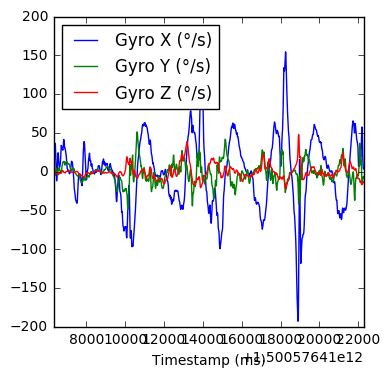

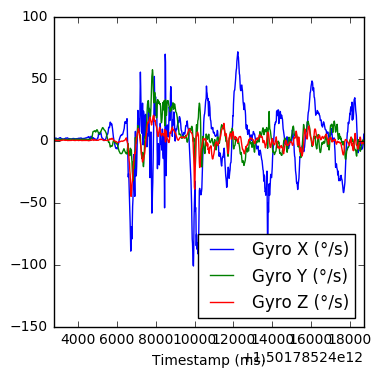

In [34]:
plot_data(act_dict,'Motor #6: Sit to Stand',0,'sacrum','gyro')
plot_data(act_dict,'Motor #6: Sit to Stand',5,'sacrum','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'anterior_thigh_left','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'anterior_thigh_left','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',0,'flexor_digitorum_right','gyro')
# plot_data(act_dict,'Motor #6: Sit to Stand',5,'flexor_digitorum_right','gyro')

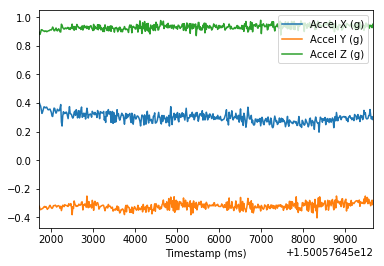

In [5]:
# Subject 1020 - OFF
plot_data(act_dict, 'Motor #7: Drawing on Paper', 0, 'dorsal_hand_right', 'accel')

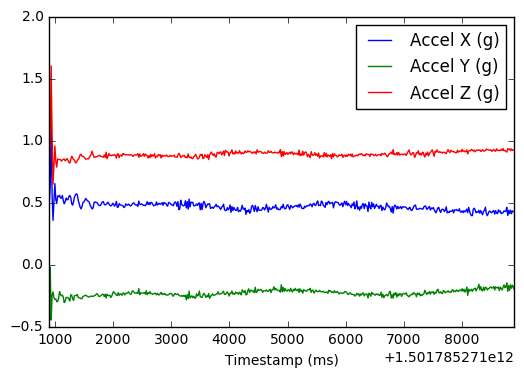

In [28]:
# Subject 1020 - ON
plot_data(act_dict, 'Motor #7: Drawing on Paper', 5, 'dorsal_hand_right', 'accel', 100, 600)

In [7]:
SubID2 = '1029'

act_dict2, timestamps2, testInfo2 = extract_data(SubID2, os.path.join(path, SubID2))

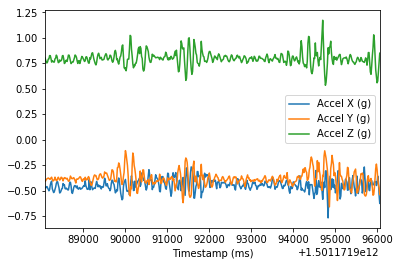

In [8]:
# Subject 1029 - OFF
plot_data(act_dict2, 'Motor #8: Typing on a Computer', 0, 'dorsal_hand_right', 'accel')

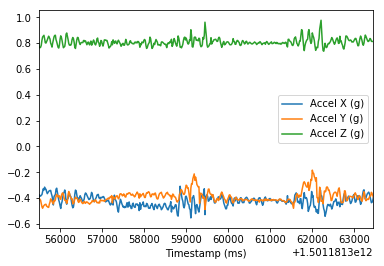

In [9]:
# Subject 1029 - ON
plot_data(act_dict2, 'Motor #8: Typing on a Computer', 5, 'dorsal_hand_right', 'accel')

In [10]:
timestamps2

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Heart Rate Variability,1501170484563,1501170844573,NaN
MDS-UPDRS #1: Finger Tapping,1501171123731,1501171140862,1
MDS-UPDRS #2: Hand Movements,1501171146588,1501171157955,1
MDS-UPDRS #3: Pronation-Supination,1501171160513,1501171169220,1
MDS-UPDRS #4: Toe Tapping,1501171171984,1501171186118,1
MDS-UPDRS #5: Leg Agility,1501171188903,1501171201086,1
MDS-UPDRS #6: Arising from Chair,1501171203594,1501171210651,1
MDS-UPDRS #7: Gait,1501171219129,1501171233768,1
MDS-UPDRS #8: Postural Stability,1501171238865,1501171245703,1


In [11]:
testInfo2

,Date,Day
0,2017-07-27,DAY 1
1,2017-08-09,DAY 2


In [12]:
def fix_errors(df, SubID, path):
#def fix_errors(df, testInfo, SubID, path):
    errors = pd.read_excel(os.path.join(path, 'PD_errorWorkbook.xlsx'), sheetname='Errors',
                          converters={'Cycle':int, 'Time Adjusted (sec)':int}).set_index('Participant').loc[int(SubID)]
    
    """# Fixes absent timestamps
    if not errors.loc[errors['Error'] == 'Absent'].empty:
        df = fix_absent(df, errors.loc[errors['Error'] == 'Absent'], testInfo)
    
    # Merges two separated timestamps
    if not errors.loc[errors['Error'] == 'Merge'].empty:
        df = fix_merge(df, errors.loc[errors['Error'] == 'Merge'], testInfo)
    
    # Splits merged timestamp
    if not errors.loc[errors['Error'] == 'Split'].empty:
        df = fix_split(df, errors.loc[errors['Error'] == 'Split'], testInfo)
        
    # Fixes duplicate timestamps
    if not errors.loc[errors['Error'] == 'Duplicate'].empty:
        df = fix_duplicate(df, errors.loc[errors['Error'] == 'Duplicate'], testInfo)
        
    # Fixes late timestamps
    if not errors.loc[errors['Error'] == 'Late'].empty:
        df = fix_late(df, errors.loc[errors['Error'] == 'Late'], testInfo)
    
    # Fixes early timestamps
    if not errors.loc[errors['Error'] == 'Early'].empty:
        df = fix_early(df, errors.loc[errors['Error'] == 'Early'], testInfo)
    
    # Fixes sensors placed in reverse (incorrect orientation)
    if not errors.loc[errors['Error'] == 'Reverse'].empty:
        df = fix_reverse(df, errors.loc[errors['Error'] == 'Reverse'], testInfo)"""
    

    
    #return df
    return errors


def fix_absent(df, error_df, testInfo):
    Day1 = testInfo.loc[testInfo['Day'] == 'DAY 1', 'Date']
    Day2 = testInfo.loc[testInfo['Day'] == 'DAY 2', 'Date']
    
    


In [13]:
timestamps2.loc['Motor #6: Sit to Stand']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Motor #6: Sit to Stand,1501171833536,1501171886451,1
Motor #6: Sit to Stand,1501174769247,1501174790218,2
Motor #6: Sit to Stand,1501176904165,1501176919567,3
Motor #6: Sit to Stand,1501178075601,1501178090349,4
Motor #6: Sit to Stand,1501179743052,1501179756545,5
Motor #6: Sit to Stand,1501181275897,1501181293980,6
Motor #6: Sit to Stand,1502300740105,1502300759498,7


In [14]:
path3 = r'C:\Users\andre\Documents\PD Study Data'
errors = fix_errors(timestamps2, SubID2, path3)
errors

,Activity,Cycle,Error,Day,Time Adjusted (sec),Type
Participant,,,,,,
1029,Motor #6: Sit to Stand,1,Early,Day 1,20,Start
1029,Motor #13: Sitting,1,Early,Day 1,7,Start
1029,MDS-UPDRS #8: Postural Stability,2,Early,Day 1,10,Start


In [15]:
timestamps.loc['MDS-UPDRS #11: Rest Tremor']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
MDS-UPDRS #11: Rest Tremor,1500575815425,1500575831066,1
MDS-UPDRS #11: Rest Tremor,1501784157062,1501784209549,2


In [16]:
errors = fix_errors(timestamps, SubID, path3)
errors

,Activity,Cycle,Error,Day,Time Adjusted (sec),Type
Participant,,,,,,
1020,Motor #9: Nuts and Bolts,1,Duplicate,Day 1,NaN,NaN
1020,MDS-UPDRS #10: Kinetic Hand Tremor,2,Late,Day 1,2,Start
1020,MDS-UPDRS #11: Rest Tremor,2,Absent,Day 1,NaN,Not tested
1020,MDS-UPDRS #7: Gait,1,Early,Day 2,5,Start
1020,Motor #5: Alternating Hand Movements,1,Late,Day 2,10,Start


In [17]:
error_df = errors.loc[errors['Error'] == 'Absent']
for i in range(0, int(error_df['Activity'].count())):
    columns = ['EventType', 'Start Timestamp (ms)', 'Stop Timestamp (ms)', 'Cycle']
    name = error_df.iloc[i]['Activity']
    cycle = error_df.iloc[i]['Cycle']
    temp_df = pd.DataFrame([name, 'NaN', 'NaN', cycle], index=columns).T.set_index('EventType')
    timestamps = timestamps.append(temp_df)
timestamps

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
Heart Rate Variability,1500574488326,1500574848328,NaN
MDS-UPDRS #11: Rest Tremor,1500575815425,1500575831066,1
MDS-UPDRS #9: Postural Hand Tremor,1500575837851,1500575842796,1
MDS-UPDRS #10: Kinetic Hand Tremor,1500575845201,1500575850709,1
MDS-UPDRS #1: Finger Tapping,1500575894522,1500575902444,1
MDS-UPDRS #2: Hand Movements,1500575905206,1500575912651,1
MDS-UPDRS #3: Pronation-Supination,1500575914789,1500575919707,1
MDS-UPDRS #4: Toe Tapping,1500575922755,1500575928707,1
MDS-UPDRS #5: Leg Agility,1500575931011,1500575936588,1


In [18]:
timestamps.loc['MDS-UPDRS #11: Rest Tremor']

,Start Timestamp (ms),Stop Timestamp (ms),Cycle
EventType,,,
MDS-UPDRS #11: Rest Tremor,1500575815425,1500575831066,1
MDS-UPDRS #11: Rest Tremor,1501784157062,1501784209549,2
MDS-UPDRS #11: Rest Tremor,NaN,NaN,2


In [19]:
for num in range(0, int(errors['Activity'].count())):
    names = errors.iloc[num]['Activity']
    print(names)

Motor #9: Nuts and Bolts
MDS-UPDRS #10: Kinetic Hand Tremor
MDS-UPDRS #11: Rest Tremor
MDS-UPDRS #7: Gait
Motor #5: Alternating Hand Movements
